In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

### 导入数据探索

In [2]:
#训练集
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training_1600000_processed_noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data_train=df[['text','target']]
data_train['target'] = data_train['target'].replace(4,1)

###测试集测试
df_test = pd.read_csv('testdata_manual_2009_06_14.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data_test=df_test[['text','target']]
data_test['target'] = data_test['target'].replace(4,1)

data_train.sample(5)

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\3339332817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['target'] = data_train['target'].replace(4,1)
C:\Users\21083\AppData\Local\Temp\ipykernel_20252\3339332817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['target'] = data_test['target'].replace(4,1)


,text,target
550735,havent been really updating my twitter acc sin...,0
639359,@tickklemeneesha uuurghhhh!!!! u didnt say hii...,0
1300172,@angelobell And you are here to tell the tale,1
327522,@TrishaRivera Ahhh bb I'm sorry to hear that. ...,0
902678,YAY! GO TAYLOR SWIFT!! come to australia again...,1


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
print('Count of columns in the data is:  ', len(data_train.columns))
print('Count of rows in the data is:  ', len(data_train))

Count of columns in the data is:   2
Count of rows in the data is:   1600000


<AxesSubplot:xlabel='target', ylabel='count'>

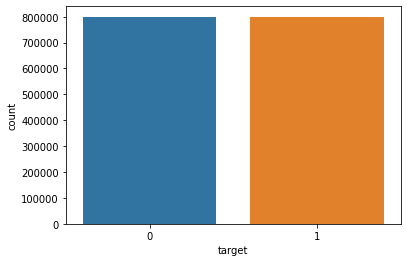

In [5]:
import seaborn as sns
sns.countplot(x='target', data=data_train)

In [6]:
data_train['target'].unique()

array([0, 1], dtype=int64)

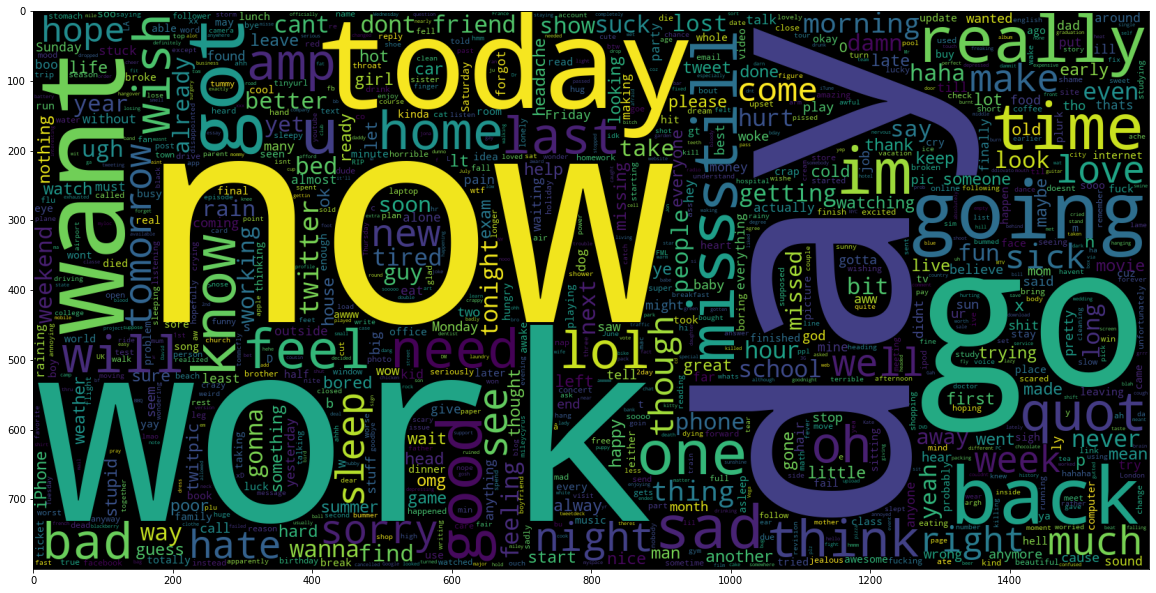

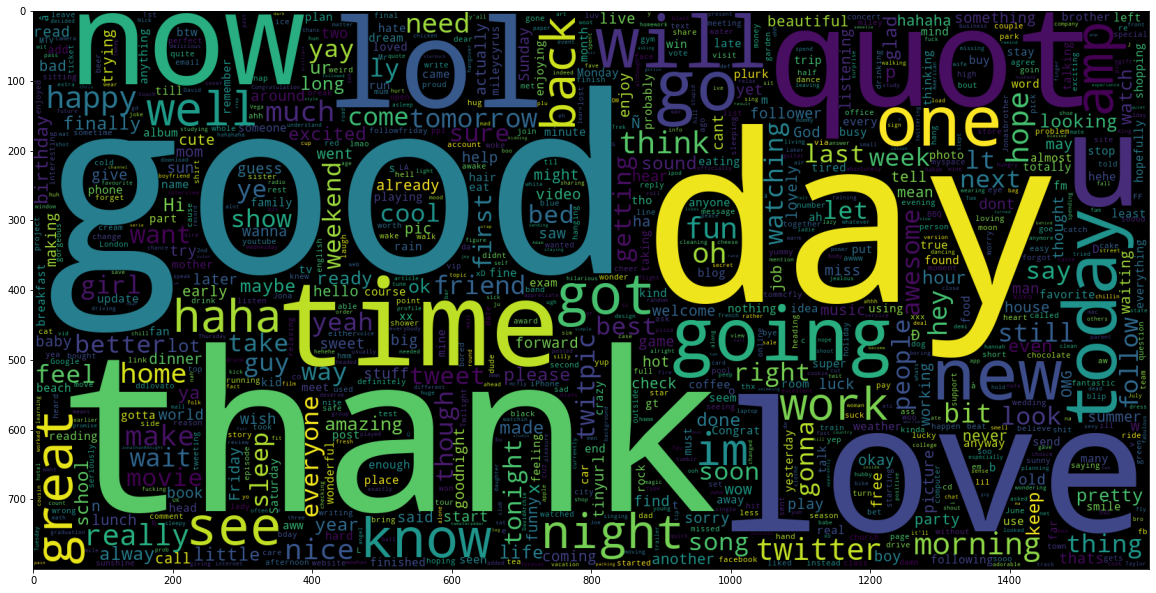

In [7]:
data_neg = data_train['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

data_pos = data_train['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [8]:
#正负样本个数
data_pos = data_train[data_train['target'] == 1]
data_neg = data_train[data_train['target'] == 0]

data_pos = data_pos.iloc[:int(800000)]    #在这里取个数
data_neg = data_neg.iloc[:int(800000)]

data_train = pd.concat([data_pos, data_neg])

In [9]:
#所有文本转小写
data_train['text']=data_train['text'].str.lower()
data_test['text']=data_test['text'].str.lower()
data_train['text'].tail()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\4200895455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text']=data_test['text'].str.lower()


799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object

In [10]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [11]:
# 去掉停用词
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_train['text'] = data_train['text'].apply(lambda text: cleaning_stopwords(text))
data_test['text'] = data_test['text'].apply(lambda text: cleaning_stopwords(text))
data_train['text'].head()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\4261226094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text'] = data_test['text'].apply(lambda text: cleaning_stopwords(text))


800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [12]:
# 去掉标点符号
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_train['text']= data_train['text'].apply(lambda x: cleaning_punctuations(x))
data_test['text']= data_test['text'].apply(lambda x: cleaning_punctuations(x))
data_train['text'].tail()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\2218665811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text']= data_test['text'].apply(lambda x: cleaning_punctuations(x))


799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [13]:
#去掉重复字符，不过好像没啥用
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_train['text'] = data_train['text'].apply(lambda x: cleaning_repeating_char(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_repeating_char(x))
data_train['text'].tail()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\421580985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text'] = data_test['text'].apply(lambda x: cleaning_repeating_char(x))


799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [14]:
# 删除链接
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_train['text'] = data_train['text'].apply(lambda x: cleaning_URLs(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_URLs(x))
data_train['text'].tail()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\2771970698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text'] = data_test['text'].apply(lambda x: cleaning_URLs(x))


799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [15]:
# 删除数字（0-9），因为它们不会影响大多数情感类标签
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_train['text'] = data_train['text'].apply(lambda x: cleaning_numbers(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_numbers(x))
data_train['text'].tail()

C:\Users\21083\AppData\Local\Temp\ipykernel_20252\1555192400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['text'] = data_test['text'].apply(lambda x: cleaning_numbers(x))


799995    sick spending day laying bed listening taylorswif
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, dtype: object

In [16]:
X=data_train.text
y=data_train.target
print(X,y)
print("---------")
x_test=data_test['text']
y_test=data_test['target']
print(x_test,y_test)

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
                                ...                        
799995    sick spending day laying bed listening taylorswif
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads not ...
799999    resit exams over summer wishes worked harder f...
Name: text, Length: 1600000, dtype: object 800000    1
800001    1
800002    1
800003    1
800004    1
         ..
799995    0
799996    0
799997    0
799998    0
799999    0
Name: target, Length: 1600000, dtype: int64
---------
0      stellargirl loooooooovvvvvveee kindle not dx c...
1            reading kindle love it lee childs good re

In [17]:
# 8：2划分训练集和验证集
import random
random_state = random.randint(10000,100000)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 100)

In [18]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
vectoriser.fit(x_test)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  4393


f:\MyDownload\Anaconda2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
X_train = vectoriser.transform(X_train)
X_val  = vectoriser.transform(X_val)
x_test  = vectoriser.transform(x_test)

In [20]:
def model_Evaluate(model,X_val,y_val,name=""):
  y_pred = model.predict(X_val)    #预测

  print(classification_report(y_val, y_pred))    # 评估矩阵.

  cf_matrix = confusion_matrix(y_val, y_pred)    #混淆矩阵
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title (name+" Confusion Matrix", fontdict = {'size':18}, pad = 20)
  plt.savefig (name+" Confusion Matrix", bbox_inches= 'tight')

#### 支持向量机的分类算法svc

In [21]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
# # 验证集      这个是自己看的
# model_Evaluate(SVCmodel,X_val,y_val)
# y_pred_2 = SVCmodel.predict(X_val)
# # ROC曲线
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_val, y_pred_2)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC CURVE')
# plt.legend(loc="lower right")
# plt.show()


LinearSVC()

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       177
           1       0.77      0.85      0.81       182

    accuracy                           0.79       359
   macro avg       0.80      0.79      0.79       359
weighted avg       0.80      0.79      0.79       359



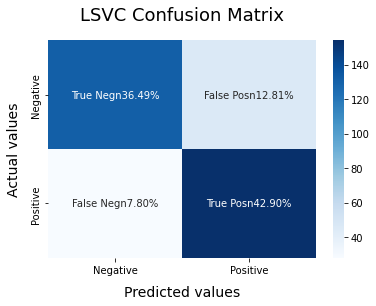

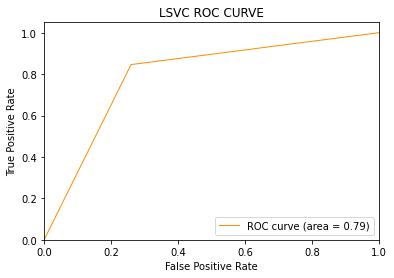

In [22]:
#测试集    这个是对外看的
model_Evaluate(SVCmodel,x_test,y_test,"LSVC")
y_pred2_test = SVCmodel.predict(x_test)
# ROC曲线
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSVC ROC CURVE')
plt.legend(loc="lower right")
plt.savefig ( 'LSVC ROC CURVE', bbox_inches= 'tight')
plt.show()


### 逻辑回归算法

In [23]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1, solver='sag')
LRmodel.fit(X_train, y_train)

# class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
# 											intercept_scaling=1, class_weight=None, random_state=None, 
# 											solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
# 											warm_start=False, n_jobs=None, l1_ratio=None)

# #验证集
# model_Evaluate(LRmodel,X_val,y_val)
# y_pred3 = LRmodel.predict(X_val)
# #roc曲线
# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_val, y_pred3)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC CURVE')
# plt.legend(loc="lower right")
# plt.show()

LogisticRegression(C=2, max_iter=1000, n_jobs=-1, solver='sag')

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       177
           1       0.79      0.87      0.83       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



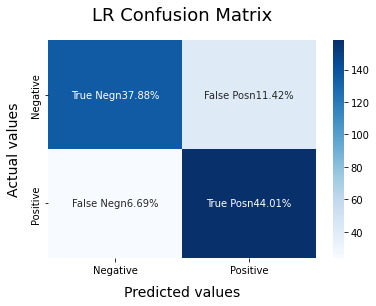

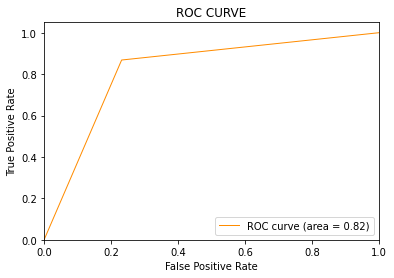

In [24]:
#测试集
model_Evaluate(LRmodel,x_test,y_test,"LR")
y_pred3_test = LRmodel.predict(x_test)
#roc曲线
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.savefig ( 'LR ROC CURVE', bbox_inches= 'tight')
plt.show()

### SGD

              precision    recall  f1-score   support

           0       0.87      0.66      0.75       177
           1       0.73      0.91      0.81       182

    accuracy                           0.78       359
   macro avg       0.80      0.78      0.78       359
weighted avg       0.80      0.78      0.78       359



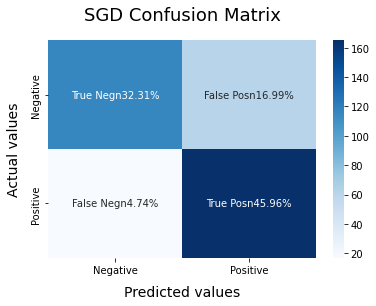

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

lr = SGDClassifier(loss='log', max_iter=1000, n_jobs=-1)
clf =lr.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(X_train, y_train)

model_Evaluate(model,x_test,y_test,"SGD")
y_test_pred = model.predict_proba(x_test)


# from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC CURVE')
# plt.legend(loc="lower right")
# plt.savefig ( 'LR ROC CURVE', bbox_inches= 'tight')
# plt.show()

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
#投票法


clf1 = LogisticRegression()
clf2 = SGDClassifier()
clf3 = LinearSVC()
# eclf1 = VotingClassifier(estimators=[('LR', clf1), ('SGDC', clf2),('LSVC', clf3)], voting='hard')
eclf1 = VotingClassifier(estimators=[('LR', clf1), ('SGDC', clf2)], voting='hard')
eclf1.fit(X_train, y_train)

# predictions_val = eclf1.predict(X_val)
# print(classification_report(y_val, predictions_val))

predictions_test = eclf1.predict(x_test)
print(classification_report(y_test, predictions_test))




f:\MyDownload\Anaconda2022\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.86      0.78      0.82       177
           1       0.80      0.88      0.84       182

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359



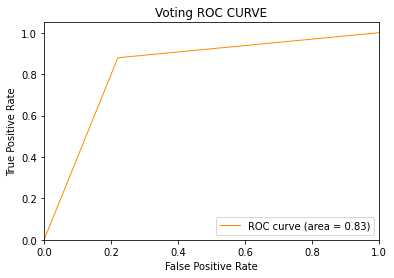

In [31]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Voting ROC CURVE')
plt.legend(loc="lower right")
plt.savefig ( 'Voting ROC CURVE', bbox_inches= 'tight')
plt.show()